# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [ ]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.7.0'

#### Load Image Data

In [ ]:
#pwd
#cd /projectnb2/cs440/students/wlew/.ipynb_checkpoints
#rm task1_template-checkpoint.ipynb
#rmdir /projectnb2/cs440/students/wlew/.ipynb_checkpoints
#cd /projectnb2/cs440/students/wlew/Covid_Data_GradientCrescent/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

DATA_LIST = os.listdir('drive/My Drive/Class Challenge/CovidGD/two/train')
DATASET_PATH  = 'drive/My Drive/Class Challenge/CovidGD/two/train'
TEST_DIR =  'drive/My Drive/Class Challenge/CovidGD/two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST) 
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.00003 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [ ]:
from keras.applications.vgg16 import VGG16
sequential_1 = tf.keras.models.Sequential(VGG16(include_top=False, weights="imagenet", input_shape=(224,224, 3)))
for layer in sequential_1.layers:
    layer.trainable = False
for i, layer in enumerate(sequential_1.layers):
    print(i, layer.name, layer.trainable)
sequential_1.summary()

58900480/58889256 [==============================] - 1s 0us/step
0 vgg16 False
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from keras.applications.vgg16 import VGG16

sequential_1.add(tf.keras.layers.Flatten())
#sequential_1.add(tf.keras.layers.Dropout(0.25))
sequential_1.add(tf.keras.layers.Dense(256, activation='relu'))
sequential_1.add(tf.keras.layers.Dense(1))
sequential_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
import keras
import tensorflow as tf


sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



#### [5 points] Train Model

In [ ]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

sequential_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
model = sequential_1.fit(train_batches, validation_data=valid_batches, epochs=NUM_EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN, 
                 validation_steps = STEP_SIZE_VALID)

11
3


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40
10/10 [==============================] - 69s 6s/step - loss: 2.3403 - accuracy: 0.5319 - val_loss: 0.6884 - val_accuracy: 0.6500
Epoch 2/40
10/10 [==============================] - 6s 579ms/step - loss: 0.4617 - accuracy: 0.8191 - val_loss: 0.3558 - val_accuracy: 0.7000
Epoch 3/40
10/10 [==============================] - 6s 558ms/step - loss: 0.3280 - accuracy: 0.8723 - val_loss: 0.0922 - val_accuracy: 1.0000
Epoch 4/40
10/10 [==============================] - 6s 550ms/step - loss: 0.2422 - accuracy: 0.8936 - val_loss: 0.0913 - val_accuracy: 1.0000
Epoch 5/40
10/10 [==============================] - 5s 533ms/step - loss: 0.2772 - accuracy: 0.9043 - val_loss: 0.0747 - val_accuracy: 1.0000
Epoch 6/40
10/10 [==============================] - 6s 568ms/step - loss: 0.2504 - accuracy: 0.8936 - val_loss: 0.1638 - val_accuracy: 0.9500
Epoch 7/40
10/10 [==============================] - 6s 595ms/step - loss: 0.3234 - accuracy: 0.8936 - val_loss: 0.4035 - val_accuracy: 0.8500
Epoch 8/

#### [5 points] Plot Accuracy and Loss During Training

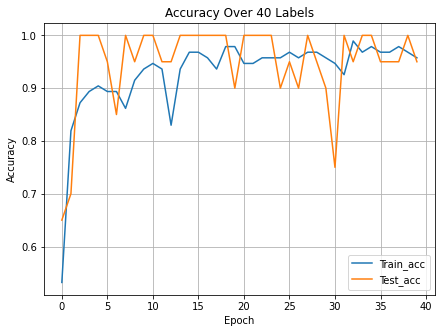

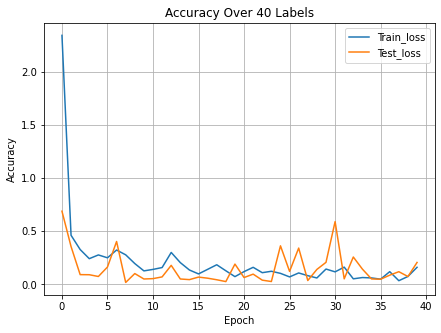

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0, figsize =(7,5))

#plt.subplot(1, 2, 1) 
plt.plot(model.history['accuracy'], label='Train_acc')
plt.grid()
plt.plot(model.history['val_accuracy'], label = 'Test_acc')
plt.title("Accuracy Over 40 Labels")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.figure(1, figsize =(7,5))

#plt.subplot(1, 2, 2) 
plt.plot(model.history['loss'], label='Train_loss')
plt.grid()
plt.plot(model.history['val_loss'], label = 'Test_loss')
plt.title("Accuracy Over 40 Labels")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

#### Plot Test Results

Found 18 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


18/18 [==============================] - 10s 508ms/step
covid/nejmoa2001191_f3-PA.jpeg


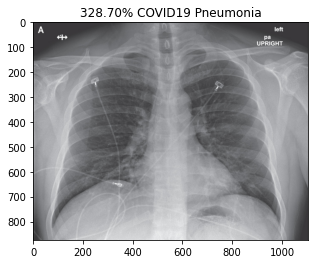

covid/nejmoa2001191_f4.jpeg


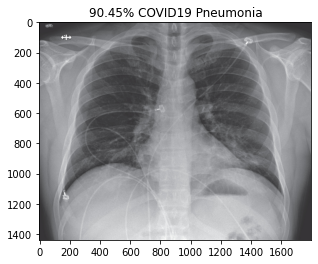

covid/nejmoa2001191_f5-PA.jpeg


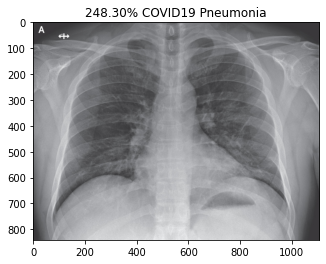

covid/radiol.2020200490.fig3.jpeg


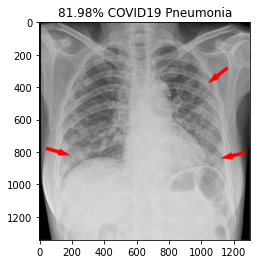

covid/ryct.2020200028.fig1a.jpeg


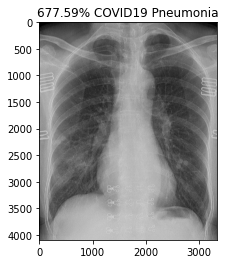

covid/ryct.2020200034.fig2.jpeg


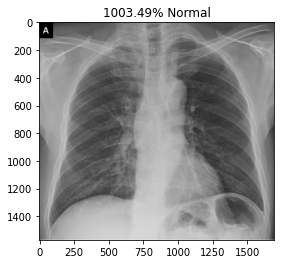

covid/ryct.2020200034.fig5-day0.jpeg


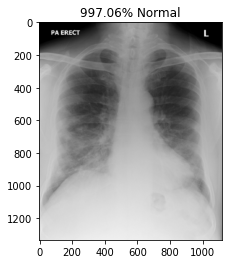

covid/ryct.2020200034.fig5-day4.jpeg


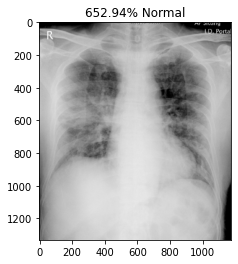

covid/ryct.2020200034.fig5-day7.jpeg


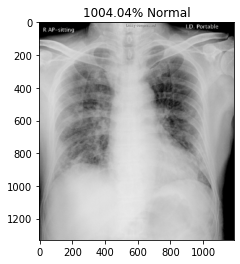

normal/NORMAL2-IM-1385-0001.jpeg


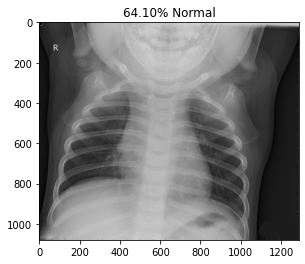

normal/NORMAL2-IM-1396-0001.jpeg


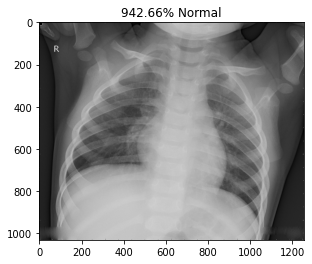

normal/NORMAL2-IM-1400-0001.jpeg


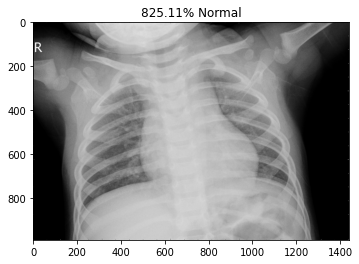

normal/NORMAL2-IM-1401-0001.jpeg


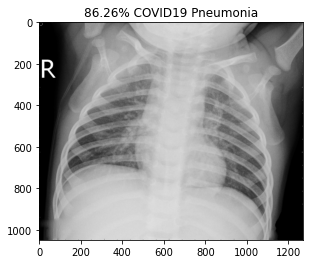

normal/NORMAL2-IM-1406-0001.jpeg


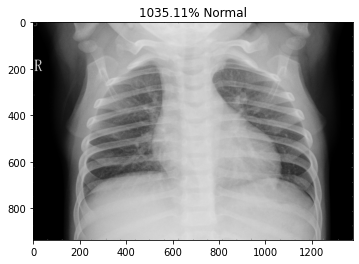

normal/NORMAL2-IM-1412-0001.jpeg


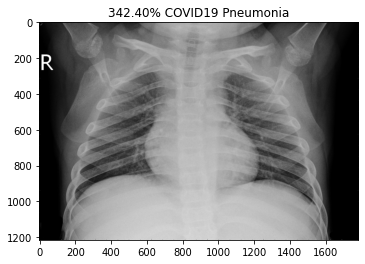

normal/NORMAL2-IM-1419-0001.jpeg


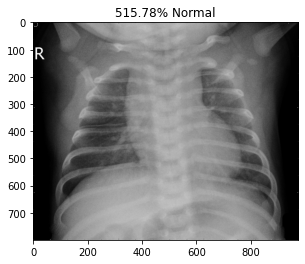

normal/NORMAL2-IM-1422-0001.jpeg


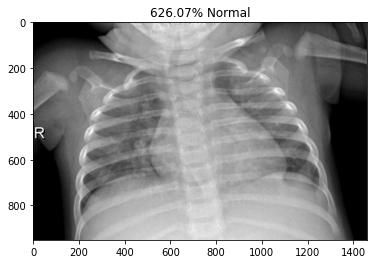

normal/NORMAL2-IM-1423-0001.jpeg


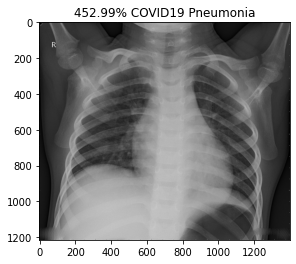

In [ ]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
pred = sequential_1.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [ ]:
#x_transformed = TNES()..
#labels = tsne_eval_generator_labels

Found 130 images belonging to 2 classes.
(130, 256)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


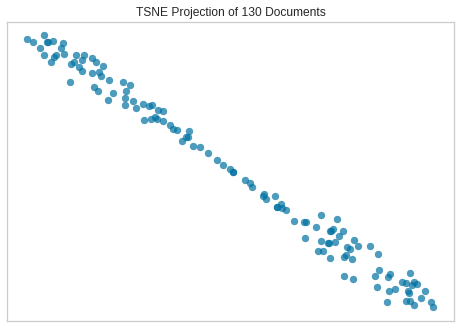

In [ ]:
from sklearn.manifold import TSNE
from yellowbrick.text import TSNEVisualizer

intermediate_layer_model = tf.keras.Model(inputs=sequential_1.input,
                                        outputs=sequential_1.get_layer('dense').output)

tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")

predictions = intermediate_layer_model.predict(tsne_data_generator)
labels = tsne_data_generator.labels
print(predictions.shape)
x_transformed = TSNE().fit_transform(predictions)


In [ ]:
print(labels)
print(x_transformed.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(130, 2)


TypeError: ignored

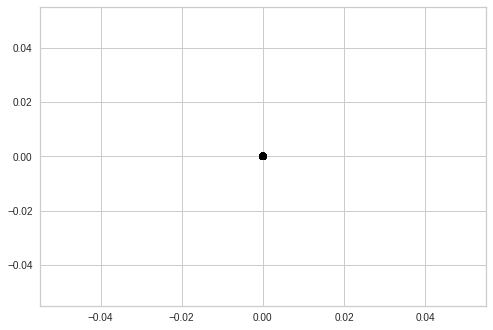

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
x_vals = [val[0] for val in x_transformed]
y_vals = [val[1] for val in x_transformed]
plt.scatter(x_vals,y_vals, c = labels)
m = TSNEVisualizer(labels=labels)
tfidf = TfidfVectorizer()
x_vals = tfidf.fit_transform()
m.fit(x_vals,y_vals)
m.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->